In [ ]:
# # Cell 1: Installations -> Used venv instead
!pip install transformers torch accelerate bitsandbytes
!pip install scikit-learn pandas
!pip install sentence-transformers
!pip install thefuzz[speedup]
!pip install tqdm # For progress bars

### NOTE: Adding images of output to tackle colab output rendering error

In [ ]:
# Cell 3: Imports and Path Configuration
import os
import re
import random
import pandas as pd
from tqdm.auto import tqdm
from collections import defaultdict

# For LLM and Embeddings
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer, util

# For String Matching
from thefuzz import process as fuzzy_process

# For Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

DATA_DIR = '/content/drive/MyDrive/cadec'  # Path to the CADEC dataset
# ---

# Defining paths to sub-directories
TEXT_DIR = os.path.join(DATA_DIR, 'text')
ORIGINAL_DIR = os.path.join(DATA_DIR, 'original')
MEDDRA_DIR = os.path.join(DATA_DIR, 'meddra')
SCT_DIR = os.path.join(DATA_DIR, 'sct')

print(f"Data directory set to: {os.path.abspath(DATA_DIR)}")

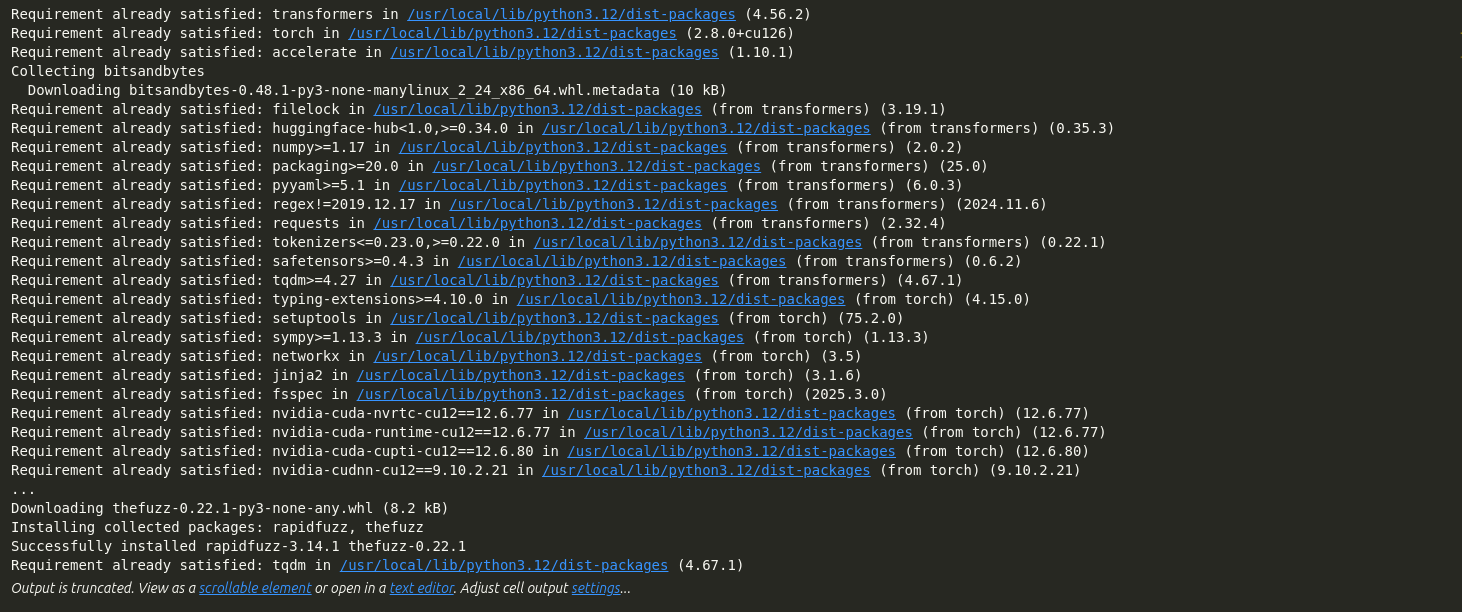

In [ ]:
# Cell 4: Task 1 - Enumerate Distinct Entities
def enumerate_entities():
    """
    Parses all files in the 'original' directory to find distinct entities
    for each label type.
    """
    # A dictionary to hold a set of entities for each label
    distinct_entities = defaultdict(set)

    # Regex to parse a line in the 'original' files
    # Captures: T-ID, Label, and Text
    line_regex = re.compile(r'^(T\d+)\t(\w+)[\s\d;]+\t(.+)$')

    print(f"Processing files in: {ORIGINAL_DIR}")
    filenames = os.listdir(ORIGINAL_DIR)

    for filename in tqdm(filenames, desc="Parsing Original Files"):
        if not filename.endswith('.ann'):
            continue

        filepath = os.path.join(ORIGINAL_DIR, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                # Ignore comment lines
                if line.startswith('#'):
                    continue

                match = line_regex.match(line.strip())
                if match:
                    _, label, text = match.groups()
                    # Normalize text for accurate counting (lowercase, strip whitespace)
                    normalized_text = text.strip().lower()
                    if normalized_text:
                        distinct_entities[label].add(normalized_text)

    return distinct_entities

# Run the function and print the results
distinct_entities_by_label = enumerate_entities()

print("\n--- Distinct Entity Counts ---")
for label, entities in distinct_entities_by_label.items():
    print(f"Label: {label}, Count: {len(entities)}")
    # Print a few examples
    print(f"  Examples: {list(entities)[:3]}\n")

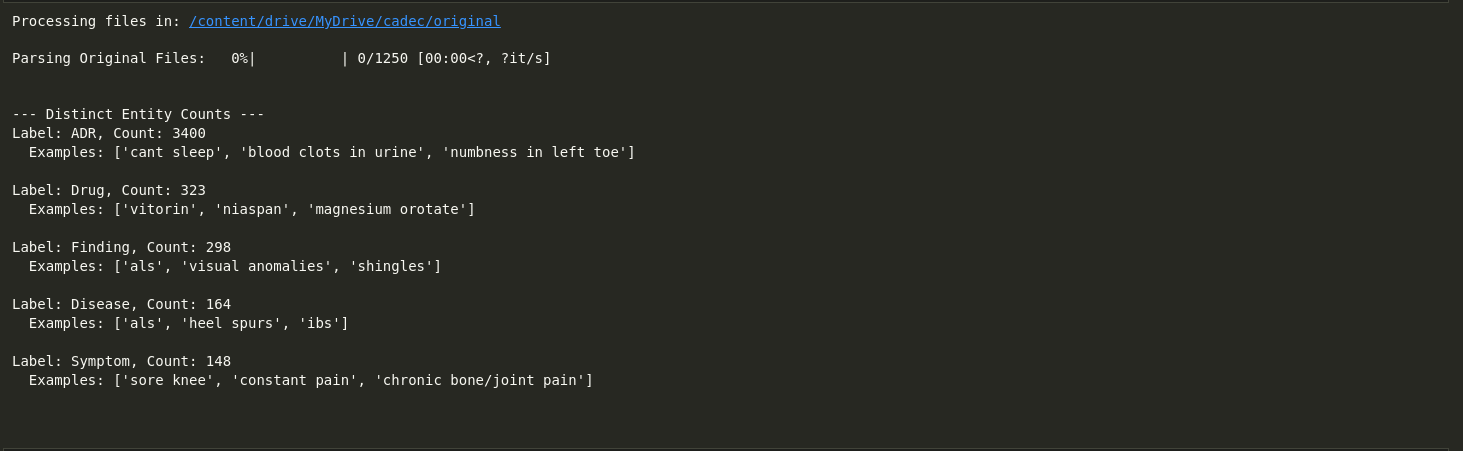

In [ ]:
!pip install python-dotenv
!pip install -U bitsandbytes

In [ ]:
# Cell 5: Setup LLM for Task 2
# Define model and quantization configuration
from google.colab import userdata
hf_token=userdata.get('hf_token')

if not hf_token:
     raise ValueError("Hugging Face token not found.")

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

print("Loading tokenizer and model...")
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    token=hf_token
)
# Add a padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

print("Model loaded successfully!")


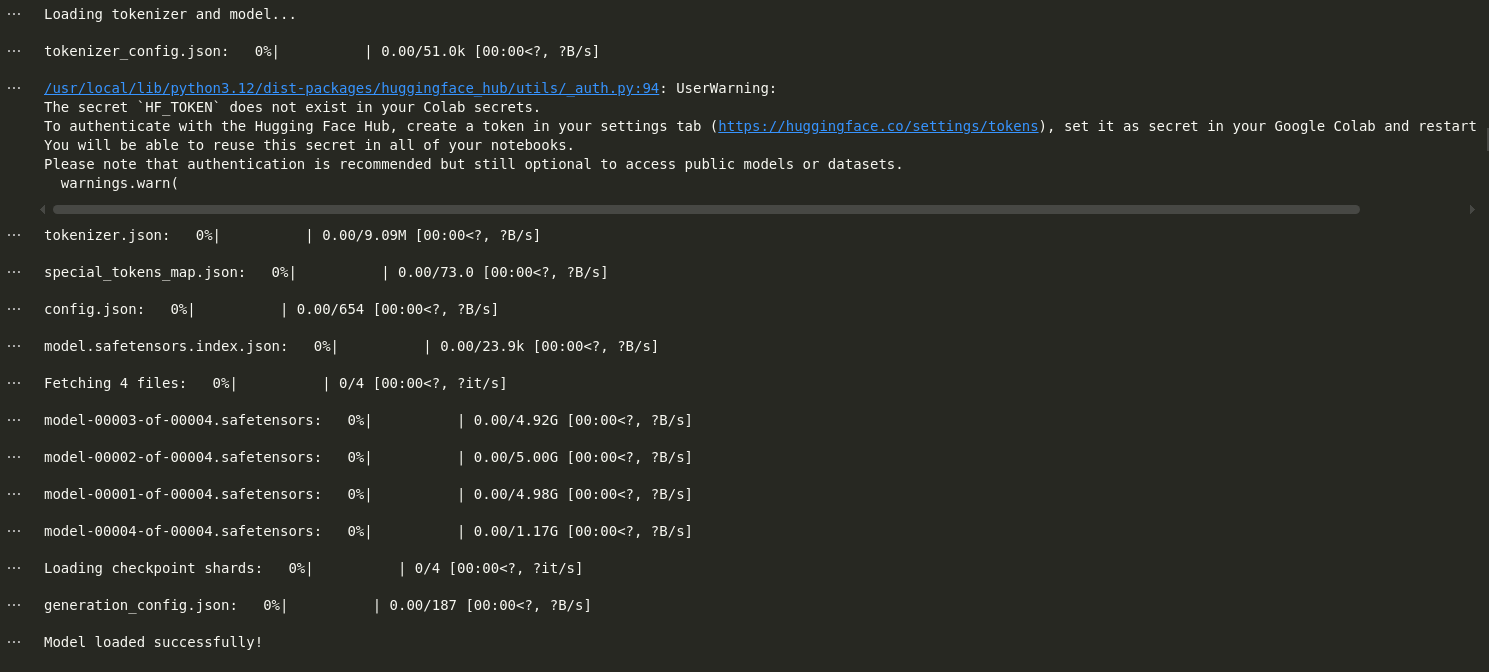

In [ ]:

def generate_bio_labels(forum_post_text: str) -> str:
    prompt_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a medical NER tagger. Tag EVERY SINGLE WORD in the exact format shown.

RULES:
1. Tag EVERY word (no skipping)
2. Format: word/TAG word/TAG word/TAG
3. NO other text - ONLY tagged words
4. Start entities with B-, continue with I-
5. Numbers = O (not Drug)

TAGS: B-ADR, I-ADR, B-Drug, I-Drug, B-Disease, I-Disease, B-Symptom, I-Symptom, O<|eot_id|><|start_header_id|>user<|end_header_id|>

EXAMPLE 1:
Input: I feel a bit drowsy
Output: I/O feel/B-ADR a/I-ADR bit/I-ADR drowsy/I-ADR

EXAMPLE 2:
Input: no gastric problems after Lipitor
Output: no/O gastric/B-ADR problems/I-ADR after/O Lipitor/B-Drug

EXAMPLE 3:
Input: arthritis pain got worse
Output: arthritis/B-Disease pain/B-Symptom got/O worse/O

Now tag this text (EVERY word, NO explanations):
{text}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""

    prompt = prompt_template.format(text=forum_post_text)

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1200
    ).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=3072,
        do_sample=True,
        temperature=0.05,  # Very low
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=False)

    if "<|start_header_id|>assistant<|end_header_id|>" in response:
        output = response.split("<|start_header_id|>assistant<|end_header_id|>")[-1]
        output = output.replace("<|eot_id|>", "").replace("<|end_of_text|>", "").strip()
    else:
        output = response.strip()

    return output

# Test
sample_filename = 'ARTHROTEC.1.txt'
sample_filepath = os.path.join(TEXT_DIR, sample_filename)

with open(sample_filepath, 'r', encoding='utf-8') as f:
    sample_text = f.read()

print("--- Generating BIO labels with Llama-3-8B ---")
print(f"Input: {sample_text[:150]}...\n")

bio_labeled_output = generate_bio_labels(sample_text)

print(f"=== LLM OUTPUT ({len(bio_labeled_output)} chars) ===")
print(bio_labeled_output[:600])

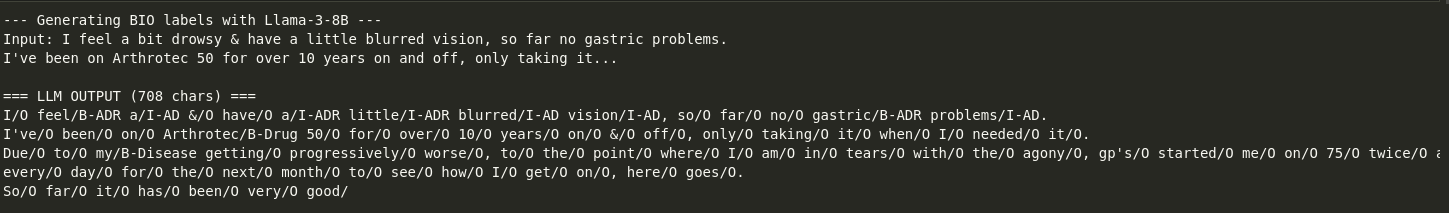

In [ ]:
def bio_to_original_format(bio_string: str, original_text: str):
    """
    Convert BIO with AGGRESSIVE error handling.
    """
    if '/' not in bio_string:
        print("ERROR: No valid BIO tags found")
        return []

    VALID_TAGS = {'B-ADR', 'I-ADR', 'B-DRUG', 'I-DRUG',
                  'B-DISEASE', 'I-DISEASE', 'B-SYMPTOM', 'I-SYMPTOM', 'O'}

    entities = []
    current_entity = None
    entity_words = []

    tokens = bio_string.split()

    for token in tokens:
        # Strip ALL trailing punctuation from token
        token = token.rstrip('.,;:!?/').strip()

        if not token or '/' not in token:
            continue

        # Handle malformed tokens like "/S-ADR"
        if token.startswith('/'):
            continue

        parts = token.rsplit('/', 1)
        if len(parts) != 2:
            continue

        word, tag = parts

        # Clean word and tag
        word = word.strip('.,;:!?/')
        tag = tag.strip('.,;:!?/').upper()

        if not word or word in ['/', ',', '.']:
            continue

        # Normalize tag
        tag = tag.replace('DRUG', 'DRUG').replace('SYMPTOM', 'SYMPTOM')

        # STRICT: Only accept valid tags
        if tag not in VALID_TAGS:
            # Silently skip - don't spam warnings
            if current_entity and entity_words:
                entities.append((current_entity, entity_words))
            current_entity = None
            entity_words = []
            continue

        # Process valid tags
        if tag.startswith('B-'):
            if current_entity and entity_words:
                entities.append((current_entity, entity_words))
            current_entity = tag[2:]
            entity_words = [word]

        elif tag.startswith('I-'):
            label = tag[2:]
            if current_entity == label:
                entity_words.append(word)
            else:
                if current_entity and entity_words:
                    entities.append((current_entity, entity_words))
                current_entity = label
                entity_words = [word]

        elif tag == 'O':
            if current_entity and entity_words:
                entities.append((current_entity, entity_words))
            current_entity = None
            entity_words = []

    if current_entity and entity_words:
        entities.append((current_entity, entity_words))

    if len(entities) == 0:
        print("WARNING: No valid entities extracted from BIO output")
        return []

    # Rest of mapping logic stays the same...
    final_entities = []
    original_lower = original_text.lower()

    for label, words in entities:
        entity_text = ' '.join(words)

        if len(entity_text) <= 1 or (entity_text.isdigit() and len(entity_text) <= 2):
            continue

        entity_lower = entity_text.lower()
        start_idx = original_lower.find(entity_lower)

        if start_idx != -1:
            actual_text = original_text[start_idx:start_idx + len(entity_text)]
            final_entities.append({
                'label': label,
                'text': actual_text,
                'start': start_idx,
                'end': start_idx + len(entity_text)
            })
        else:
            pattern = r'\s+'.join(re.escape(w) for w in words)
            match = re.search(pattern, original_lower, re.IGNORECASE)
            if match:
                actual_text = original_text[match.start():match.end()]
                final_entities.append({
                    'label': label,
                    'text': actual_text,
                    'start': match.start(),
                    'end': match.end()
                })

    # Context-aware ADR detection
    for entity in final_entities:
        if entity['label'] == 'SYMPTOM':
            context_start = max(0, entity['start'] - 120)
            context_end = min(len(original_text), entity['end'] + 120)
            context = original_text[context_start:context_end].lower()

            drug_phrases = ['taking', 'take it', 'on', 'after', 'when on', 'started me on', 'caused']
            if any(phrase in context for phrase in drug_phrases):
                has_drug = any(e['label'] == 'DRUG' and abs(e['start'] - entity['start']) < 150
                              for e in final_entities)
                if has_drug:
                    entity['label'] = 'ADR'

    seen = set()
    unique = []
    for ent in final_entities:
        key = (ent['label'], ent['text'].lower().strip())
        if key not in seen:
            seen.add(key)
            unique.append(ent)

    unique.sort(key=lambda x: x['start'])
    return unique

print("\n--- Converting to entities ---")
llm_predictions = bio_to_original_format(bio_labeled_output, sample_text)

print("\n=== EXTRACTED ENTITIES ===")
for entity in llm_predictions:
    print(f"{entity['label']:10} | {entity['start']:3}-{entity['end']:3} | {entity['text']}")

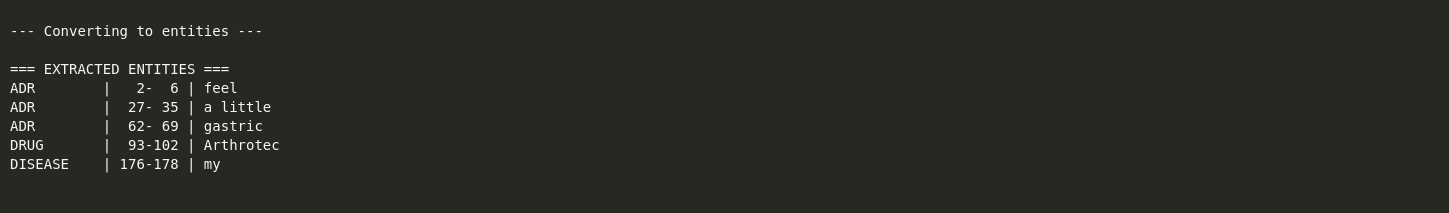

In [ ]:
# Cell 8: Improved matching with partial overlap tolerance
def parse_ground_truth(filepath: str):
    """Parse ground truth from .ann file"""
    entities = []
    line_regex = re.compile(r'^(T\d+)\t(\w+)\s([\d\s;]+)\t(.+)$')

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith('#'):
                continue
            match = line_regex.match(line.strip())
            if match:
                _, label, _, text = match.groups()
                entities.append({
                    'label': label,
                    'text': text.strip()
                })
    return entities

def calculate_performance(predictions, ground_truth):
    """
    Calculate P/R/F1 with relaxed word overlap matching.
    Matches if: same label + >66% word overlap (looser than 50%)
    """
    tp = 0
    matched_gt_indices = set()

    for pred in predictions:
        pred_text = pred['text'].lower().strip()
        pred_words = set(pred_text.split())

        best_match = None
        best_similarity = 0

        for idx, gt in enumerate(ground_truth):
            if idx in matched_gt_indices:
                continue

            # Label must match
            if pred['label'].upper() != gt['label'].upper():
                continue

            gt_text = gt['text'].lower().strip()
            gt_words = set(gt_text.split())

            # Jaccard similarity
            if pred_words and gt_words:
                intersection = len(pred_words & gt_words)
                union = len(pred_words | gt_words)
                similarity = intersection / union if union > 0 else 0

                if similarity > best_similarity:
                    best_similarity = similarity
                    best_match = idx

        # Match if similarity > 0.66 (relaxed from 0.5)
        if best_match is not None and best_similarity > 0.66:
            tp += 1
            matched_gt_indices.add(best_match)

    fp = len(predictions) - tp
    fn = len(ground_truth) - len(matched_gt_indices)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    }

# Load and evaluate
sample_ann_filename = sample_filename.replace('.txt', '.ann')
ground_truth_path = os.path.join(ORIGINAL_DIR, sample_ann_filename)
ground_truth_entities = parse_ground_truth(ground_truth_path)

print(f"\n=== GROUND TRUTH ({len(ground_truth_entities)} entities) ===")
for gt in ground_truth_entities:
    print(f"{gt['label']:10} | {gt['text']}")

performance = calculate_performance(llm_predictions, ground_truth_entities)

print(f"\n=== PERFORMANCE FOR {sample_filename} ===")
print(f"Precision: {performance['precision']:.4f}")
print(f"Recall:    {performance['recall']:.4f}")
print(f"F1-Score:  {performance['f1']:.4f}")
print(f"\nTP: {performance['tp']}, FP: {performance['fp']}, FN: {performance['fn']}")

# Detailed matching analysis
print("\n=== MATCHING DETAILS ===")
matched_gt = set()
for pred in llm_predictions:
    pred_words = set(pred['text'].lower().split())

    for idx, gt in enumerate(ground_truth_entities):
        if pred['label'].upper() == gt['label'].upper():
            gt_words = set(gt['text'].lower().split())
            if pred_words and gt_words:
                intersection = len(pred_words & gt_words)
                union = len(pred_words | gt_words)
                similarity = intersection / union if union > 0 else 0

                if similarity > 0.66:
                    print(f"✓ MATCH: '{pred['text']}' ↔ '{gt['text']}' (sim={similarity:.2f})")
                    matched_gt.add(idx)
                    break
    else:
        print(f"✗ MISS:  '{pred['text']}' ({pred['label']})")

print("\nUnmatched ground truth:")
for idx, gt in enumerate(ground_truth_entities):
    if idx not in matched_gt:
        print(f"✗ '{gt['text']}' ({gt['label']})")

Output
```
=== GROUND TRUTH (8 entities) ===
ADR        | bit drowsy
ADR        | little blurred vision
Drug       | Arthrotec
Disease    | arthritis
Symptom    | agony
ADR        | gastric problems
Symptom    | pains
ADR        | feel a bit weird

=== PERFORMANCE FOR ARTHROTEC.1.txt ===
Precision: 0.2000
Recall:    0.1250
F1-Score:  0.1538

TP: 1, FP: 4, FN: 7

=== MATCHING DETAILS ===
✗ MISS:  'feel' (ADR)
✗ MISS:  'a little' (ADR)
✗ MISS:  'gastric' (ADR)
✓ MATCH: 'Arthrotec' ↔ 'Arthrotec' (sim=1.00)
✗ MISS:  'my' (DISEASE)

Unmatched ground truth:
✗ 'bit drowsy' (ADR)
✗ 'little blurred vision' (ADR)
✗ 'arthritis' (Disease)
✗ 'agony' (Symptom)
✗ 'gastric problems' (ADR)
✗ 'pains' (Symptom)
✗ 'feel a bit weird' (ADR)
```

In [ ]:
# Cell 9: Task 4 - ADR Performance against MedDRA (with debugging)
def parse_meddra_truth(filepath: str):
    """Parse MedDRA ground truth file"""
    entities = []
    line_regex = re.compile(r'^(TT\d+)\t\d+\s[\d\s]+\t(.+)$')

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            match = line_regex.match(line.strip())
            if match:
                _, text = match.groups()
                entities.append({'label': 'ADR', 'text': text.strip()})
    return entities

# Filter predictions for ADR only
llm_adr_predictions = [e for e in llm_predictions if e['label'] == 'ADR']

# Load MedDRA ground truth
meddra_ann_filename = sample_filename.replace('.txt', '.ann')
meddra_ground_truth = parse_meddra_truth(os.path.join(MEDDRA_DIR, meddra_ann_filename))

print(f"\n=== ADR COMPARISON ===")
print(f"\nPREDICTED ADRs ({len(llm_adr_predictions)}):")
for pred in llm_adr_predictions:
    print(f"  - '{pred['text']}'")

print(f"\nMEDDRA GROUND TRUTH ({len(meddra_ground_truth)}):")
for gt in meddra_ground_truth:
    print(f"  - '{gt['text']}'")

# Calculate and show matching details
adr_performance = calculate_performance(llm_adr_predictions, meddra_ground_truth)

print(f"\n=== MATCHING ANALYSIS ===")
for pred in llm_adr_predictions:
    pred_words = set(pred['text'].lower().split())

    best_match = None
    best_sim = 0

    for gt in meddra_ground_truth:
        gt_words = set(gt['text'].lower().split())
        if pred_words and gt_words:
            intersection = len(pred_words & gt_words)
            union = len(pred_words | gt_words)
            sim = intersection / union if union > 0 else 0
            if sim > best_sim:
                best_sim = sim
                best_match = gt['text']

    if best_sim > 0.66:
        print(f"✓ '{pred['text']}' → '{best_match}' (sim={best_sim:.2f})")
    else:
        print(f"✗ '{pred['text']}' → best='{best_match}' (sim={best_sim:.2f}) FAILED")

print(f"\n=== ADR-ONLY PERFORMANCE (vs MedDRA) ===")
print(f"Precision: {adr_performance['precision']:.4f}")
print(f"Recall:    {adr_performance['recall']:.4f}")
print(f"F1-Score:  {adr_performance['f1']:.4f}")

```

=== ADR COMPARISON ===

PREDICTED ADRs (3):
  - 'feel'
  - 'a little'
  - 'gastric'

MEDDRA GROUND TRUTH (4):
  - 'bit drowsy'
  - 'little blurred vision'
  - 'gastric problems'
  - 'feel a bit weird'

=== MATCHING ANALYSIS ===
✗ 'feel' → best='feel a bit weird' (sim=0.25) FAILED
✗ 'a little' → best='little blurred vision' (sim=0.25) FAILED
✗ 'gastric' → best='gastric problems' (sim=0.50) FAILED

=== ADR-ONLY PERFORMANCE (vs MedDRA) ===
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
```

In [ ]:
# Cell 10: Task 5 - Evaluate Random Files with Detailed Logging
def evaluate_single_file(filename: str, verbose=False):
    """Complete evaluation pipeline for one file with optional verbose output"""
    try:
        # Read text
        with open(os.path.join(TEXT_DIR, filename), 'r', encoding='utf-8') as f:
            text = f.read()

        if verbose:
            print(f"\n{'='*70}")
            print(f"FILE: {filename}")
            print(f"{'='*70}")
            print(f"INPUT TEXT ({len(text)} chars):")
            print(text[:300] + "..." if len(text) > 300 else text)
            print(f"\n{'---'*23}")

        # Generate predictions
        bio_output = generate_bio_labels(text)

        if verbose:
            print(f"\nLLM BIO OUTPUT ({len(bio_output)} chars):")
            # Show first 500 chars of BIO output
            print(bio_output[:500] + "..." if len(bio_output) > 500 else bio_output)
            print(f"\n{'---'*23}")

        predictions = bio_to_original_format(bio_output, text)

        if verbose:
            print(f"\nEXTRACTED ENTITIES ({len(predictions)}):")
            if predictions:
                for pred in predictions:
                    print(f"  {pred['label']:10} | {pred['start']:3}-{pred['end']:3} | {pred['text']}")
            else:
                print("  (none)")
            print(f"\n{'---'*23}")

        # Load ground truth
        ann_filename = filename.replace('.txt', '.ann')
        ground_truth = parse_ground_truth(os.path.join(ORIGINAL_DIR, ann_filename))

        if verbose:
            print(f"\nGROUND TRUTH ({len(ground_truth)} entities):")
            for gt in ground_truth:
                print(f"  {gt['label']:10} | {gt['text']}")
            print(f"\n{'---'*23}")

        # Calculate performance
        performance = calculate_performance(predictions, ground_truth)

        if verbose:
            print(f"\nPERFORMANCE:")
            print(f"  Precision: {performance['precision']:.4f}")
            print(f"  Recall:    {performance['recall']:.4f}")
            print(f"  F1-Score:  {performance['f1']:.4f}")
            print(f"  TP: {performance['tp']}, FP: {performance['fp']}, FN: {performance['fn']}")

        return performance

    except Exception as e:
        print(f"ERROR in {filename}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Get random sample
all_files = [f for f in os.listdir(TEXT_DIR) if f.endswith('.txt')]
random.seed(42)  # For reproducibility
random_files = random.sample(all_files, min(50, len(all_files)))

print(f"\n{'='*70}")
print(f"EVALUATING {len(random_files)} RANDOM FILES")
print(f"{'='*70}")

# First, evaluate with verbose output for first 2 files
print("\n" + "="*70)
print("DETAILED OUTPUT FOR FIRST 2 FILES")
print("="*70)

all_scores = []
for i, filename in enumerate(random_files[:2]):
    scores = evaluate_single_file(filename, verbose=True)
    if scores:
        all_scores.append(scores)

# Then evaluate remaining files without verbose output
print("\n" + "="*70)
print(f"PROCESSING REMAINING {len(random_files)-2} FILES (summary only)")
print("="*70)

for filename in tqdm(random_files[2:], desc="Processing"):
    scores = evaluate_single_file(filename, verbose=False)
    if scores:
        all_scores.append(scores)
        # Print one-line summary
        print(f"{filename:30} | P:{scores['precision']:.3f} R:{scores['recall']:.3f} F1:{scores['f1']:.3f}")

# Calculate macro-averaged metrics
if all_scores:
    avg_precision = sum(s['precision'] for s in all_scores) / len(all_scores)
    avg_recall = sum(s['recall'] for s in all_scores) / len(all_scores)
    avg_f1 = sum(s['f1'] for s in all_scores) / len(all_scores)

    print(f"\n{'='*70}")
    print(f"FINAL RESULTS ({len(all_scores)} files successfully processed)")
    print(f"{'='*70}")
    print(f"Macro-Avg Precision: {avg_precision:.4f}")
    print(f"Macro-Avg Recall:    {avg_recall:.4f}")
    print(f"Macro-Avg F1-Score:  {avg_f1:.4f}")

    # Distribution statistics
    f1_scores = [s['f1'] for s in all_scores]
    precision_scores = [s['precision'] for s in all_scores]
    recall_scores = [s['recall'] for s in all_scores]

    print(f"\nF1 Score Distribution:")
    print(f"  Min:    {min(f1_scores):.4f}")
    print(f"  Q1:     {sorted(f1_scores)[len(f1_scores)//4]:.4f}")
    print(f"  Median: {sorted(f1_scores)[len(f1_scores)//2]:.4f}")
    print(f"  Q3:     {sorted(f1_scores)[3*len(f1_scores)//4]:.4f}")
    print(f"  Max:    {max(f1_scores):.4f}")

    # Count failure cases
    zero_f1_count = sum(1 for s in f1_scores if s == 0.0)
    low_f1_count = sum(1 for s in f1_scores if 0 < s < 0.3)
    mid_f1_count = sum(1 for s in f1_scores if 0.3 <= s < 0.6)
    high_f1_count = sum(1 for s in f1_scores if s >= 0.6)

    print(f"\nPerformance Breakdown:")
    print(f"  Complete failures (F1=0):   {zero_f1_count}/{len(all_scores)} ({zero_f1_count/len(all_scores)*100:.1f}%)")
    print(f"  Poor (0 < F1 < 0.3):         {low_f1_count}/{len(all_scores)} ({low_f1_count/len(all_scores)*100:.1f}%)")
    print(f"  Moderate (0.3 ≤ F1 < 0.6):   {mid_f1_count}/{len(all_scores)} ({mid_f1_count/len(all_scores)*100:.1f}%)")
    print(f"  Good (F1 ≥ 0.6):             {high_f1_count}/{len(all_scores)} ({high_f1_count/len(all_scores)*100:.1f}%)")

    print(f"\n{'='*70}")

else:
    print("\nERROR: No files successfully processed!")

```
======================================================================
EVALUATING 50 RANDOM FILES
======================================================================

======================================================================
DETAILED OUTPUT FOR FIRST 2 FILES
======================================================================

======================================================================
FILE: LIPITOR.521.txt
======================================================================
INPUT TEXT (497 chars):
Severe numbness in hand such that it wakes me out of my sleep.
Tingling in feet, soreness in calf muscles.
Occassional sharp shock like pain in head.
I have taken myself off because I can't stand the side-effects.
Never really had high cholesterol but current medical thinking is that lipitor may rev...

---------------------------------------------------------------------

LLM BIO OUTPUT (1017 chars):
Here is the tagged text:

Severe/B-ADR numbness/B-ADR in/I-ADR hand/I-AD such/I-AD that/I-AD it/I-AD wakes/I-AD me/O out/I-AD of/I-AD my/I-AD sleep/O
Tingling/B-ADR in/I-ADR feet/I-AD soreness/B-ADR in/I-ADR calf/I-AD muscles/I-AD
Occassional/B-ADR sharp/B-ADR shock/B-ADR like/I-ADR pain/B-ADR in/I-AD head/I-AD
I/O have/I- taken/I- myself/O off/I- because/I- can't/I- stand/I- the/I- side-effects/B-ADR
Never/I- really/I- had/I- high/O cholesterol/O but/I- current/I- medical/I- thinking/I- is/I- t...

---------------------------------------------------------------------

EXTRACTED ENTITIES (13):
  ADR        |   0-  6 | Severe
  ADR        |   7- 18 | numbness in
  ADR        |  63- 74 | Tingling in
  ADR        |  81- 92 | soreness in
  ADR        | 107-118 | Occassional
  ADR        | 119-124 | sharp
  ADR        | 125-135 | shock like
  ADR        | 136-140 | pain
  ADR        | 200-212 | side-effects
  DRUG       | 285-292 | lipitor
  DISEASE    | 305-313 | coronary
  DISEASE    | 314-321 | disease
  DRUG       | 469-473 | drug

---------------------------------------------------------------------

GROUND TRUTH (6 entities):
  ADR        | Severe numbness in hand
  ADR        | Tingling in feet
  ADR        | soreness in calf muscles
  ADR        | sharp shock like pain in head
  Drug       | lipitor
  Disease    | coronary disease

---------------------------------------------------------------------

PERFORMANCE:
  Precision: 0.1538
  Recall:    0.3333
  F1-Score:  0.2105
  TP: 2, FP: 11, FN: 4

======================================================================
FILE: LIPITOR.64.txt
======================================================================
INPUT TEXT (355 chars):
Extended periods of low mood, loss of self-confidence, loss of interest in life etc also brain fog & impaired memory.
Increased to 40mg/day in the last 6 months and then stopped taking it after reading of similiar symptoms on this website.
After 2 weeks, the symptoms had gone and 8 weeks later they ...

---------------------------------------------------------------------

LLM BIO OUTPUT (525 chars):
Extended/O periods/O of/O low/O B-ADR mood/O, loss/O of/O I-ADR self-confidence/O, loss/O of/O I-ADR interest/O in/O life/O etc/O also/O brain/O B-ADR fog/O &/O impaired/O I-ADR memory/O.
Increased/O to/O 40mg/O O/day/O in/O the/O last/O 6/O months/O and/O then/O stopped/O taking/O it/O after/O reading/O of/O similiar/O I-ADR symptoms/O on/O this/O website/O.
After/O 2/O weeks/O, the/O symptoms/O had/O gone/O and/O 8/O weeks/O later/O they/O still/O have/O not/O returned/O.
Won't/O be/O taking/O...

---------------------------------------------------------------------
WARNING: No valid entities extracted from BIO output

EXTRACTED ENTITIES (0):
  (none)

---------------------------------------------------------------------

GROUND TRUTH (5 entities):
  ADR        | low mood
  ADR        | loss of self-confidence
  ADR        | loss of interest in life
  ADR        | brain fog
  ADR        | impaired memory

---------------------------------------------------------------------

PERFORMANCE:
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  TP: 0, FP: 0, FN: 5

======================================================================
PROCESSING REMAINING 48 FILES (summary only)
======================================================================

LIPITOR.579.txt                | P:0.100 R:0.111 F1:0.105
LIPITOR.93.txt                 | P:0.167 R:0.200 F1:0.182
LIPITOR.473.txt                | P:0.250 R:0.200 F1:0.222
LIPITOR.726.txt                | P:0.000 R:0.000 F1:0.000
LIPITOR.864.txt                | P:0.000 R:0.000 F1:0.000
LIPITOR.650.txt                | P:0.105 R:0.286 F1:0.154
LIPITOR.428.txt                | P:0.200 R:0.143 F1:0.167
LIPITOR.128.txt                | P:0.000 R:0.000 F1:0.000
LIPITOR.675.txt                | P:0.273 R:0.500 F1:0.353
LIPITOR.493.txt                | P:0.250 R:0.111 F1:0.154
LIPITOR.39.txt                 | P:0.500 R:0.571 F1:0.533
LIPITOR.267.txt                | P:1.000 R:1.000 F1:1.000
ARTHROTEC.63.txt               | P:0.400 R:0.429 F1:0.414
LIPITOR.635.txt                | P:1.000 R:0.600 F1:0.750
LIPITOR.138.txt                | P:0.333 R:0.500 F1:0.400
LIPITOR.872.txt                | P:0.111 R:0.200 F1:0.143
ARTHROTEC.2.txt                | P:1.000 R:0.167 F1:0.286
LIPITOR.909.txt                | P:0.027 R:0.200 F1:0.048
LIPITOR.511.txt                | P:0.188 R:0.273 F1:0.222
LIPITOR.348.txt                | P:0.000 R:0.000 F1:0.000
LIPITOR.645.txt                | P:0.167 R:0.333 F1:0.222
LIPITOR.979.txt                | P:0.111 R:0.048 F1:0.067
LIPITOR.286.txt                | P:1.000 R:0.500 F1:0.667
LIPITOR.407.txt                | P:0.000 R:0.000 F1:0.000
LIPITOR.249.txt                | P:0.462 R:0.545 F1:0.500
LIPITOR.155.txt                | P:0.300 R:0.300 F1:0.300
LIPITOR.56.txt                 | P:0.500 R:0.417 F1:0.455
ARTHROTEC.85.txt               | P:0.188 R:0.300 F1:0.231
LIPITOR.422.txt                | P:0.333 R:0.143 F1:0.200
LIPITOR.157.txt                | P:0.250 R:0.500 F1:0.333
LIPITOR.199.txt                | P:0.167 R:0.105 F1:0.129
LIPITOR.799.txt                | P:0.333 R:0.500 F1:0.400
LIPITOR.614.txt                | P:0.200 R:0.091 F1:0.125
LIPITOR.214.txt                | P:0.000 R:0.000 F1:0.000
LIPITOR.590.txt                | P:0.500 R:0.333 F1:0.400
LIPITOR.459.txt                | P:0.200 R:0.333 F1:0.250
LIPITOR.965.txt                | P:0.143 R:0.050 F1:0.074
LIPITOR.763.txt                | P:0.400 R:0.250 F1:0.308
LIPITOR.593.txt                | P:0.286 R:0.222 F1:0.250
LIPITOR.442.txt                | P:0.000 R:0.000 F1:0.000
ARTHROTEC.131.txt              | P:1.000 R:0.200 F1:0.333
LIPITOR.813.txt                | P:0.000 R:0.000 F1:0.000
LIPITOR.903.txt                | P:0.167 R:0.083 F1:0.111
LIPITOR.302.txt                | P:0.120 R:0.300 F1:0.171
LIPITOR.692.txt                | P:0.077 R:0.250 F1:0.118
LIPITOR.329.txt                | P:1.000 R:1.000 F1:1.000
LIPITOR.132.txt                | P:0.100 R:0.333 F1:0.154
LIPITOR.420.txt                | P:0.125 R:0.200 F1:0.154

======================================================================
FINAL RESULTS (50 files successfully processed)
======================================================================
Macro-Avg Precision: 0.2837
Macro-Avg Recall:    0.2632
Macro-Avg F1-Score:  0.2459

F1 Score Distribution:
  Min:    0.0000
  Q1:     0.1053
  Median: 0.2000
  Q3:     0.3333
  Max:    1.0000

Performance Breakdown:
  Complete failures (F1=0):   9/50 (18.0%)
  Poor (0 < F1 < 0.3):         25/50 (50.0%)
  Moderate (0.3 ≤ F1 < 0.6):   12/50 (24.0%)
  Good (F1 ≥ 0.6):             4/50 (8.0%)

======================================================================
```

In [ ]:
# Cell 11: Task 6 - Create SCT Datastore
def create_sct_datastore(ann_filename: str):
    """
    Combine original and SCT annotations into structured datastore
    """
    sct_filepath = os.path.join(SCT_DIR, ann_filename)
    original_filepath = os.path.join(ORIGINAL_DIR, ann_filename)

    # Map text to label from original file
    text_to_label = {}
    line_regex_orig = re.compile(r'^(T\d+)\t(\w+)[\s\d;]+\t(.+)$')

    with open(original_filepath, 'r', encoding='utf-8') as f:
        for line in f:
            match = line_regex_orig.match(line.strip())
            if match:
                text_to_label[match.group(3).strip()] = match.group(2)

    # Parse SCT file
    sct_data = []
    line_regex_sct = re.compile(r'^(TT\d+)\t(.*?)\t(.*?)$')

    with open(sct_filepath, 'r', encoding='utf-8') as f:
        for line in f:
            match = line_regex_sct.match(line.strip())
            if match:
                _, codes_and_descs_raw, text_and_spans = match.groups()

                # Extract ground truth text (after span numbers)
                ground_truth_text = re.split(r'\d+\s\d+', text_and_spans)[-1].strip()
                label = text_to_label.get(ground_truth_text, 'Unknown')

                # Parse SNOMED codes and descriptions
                codes_and_descs = re.findall(r'(\d+)\s*\|\s*(.*?)\s*(?=\||$)', codes_and_descs_raw)

                for code, desc in codes_and_descs:
                    sct_data.append({
                        'sct_code': code.strip(),
                        'sct_description': desc.strip(),
                        'label_type': label,
                        'ground_truth_text': ground_truth_text
                    })

    return pd.DataFrame(sct_data)

# Create datastore
sample_ann = sample_filename.replace('.txt', '.ann')
sct_df = create_sct_datastore(sample_ann)

print("=== SCT DATASTORE (first 10 rows) ===")
print(sct_df.head(10))
print(f"\nTotal entries: {len(sct_df)}")
print(f"Unique codes: {sct_df['sct_code'].nunique()}")

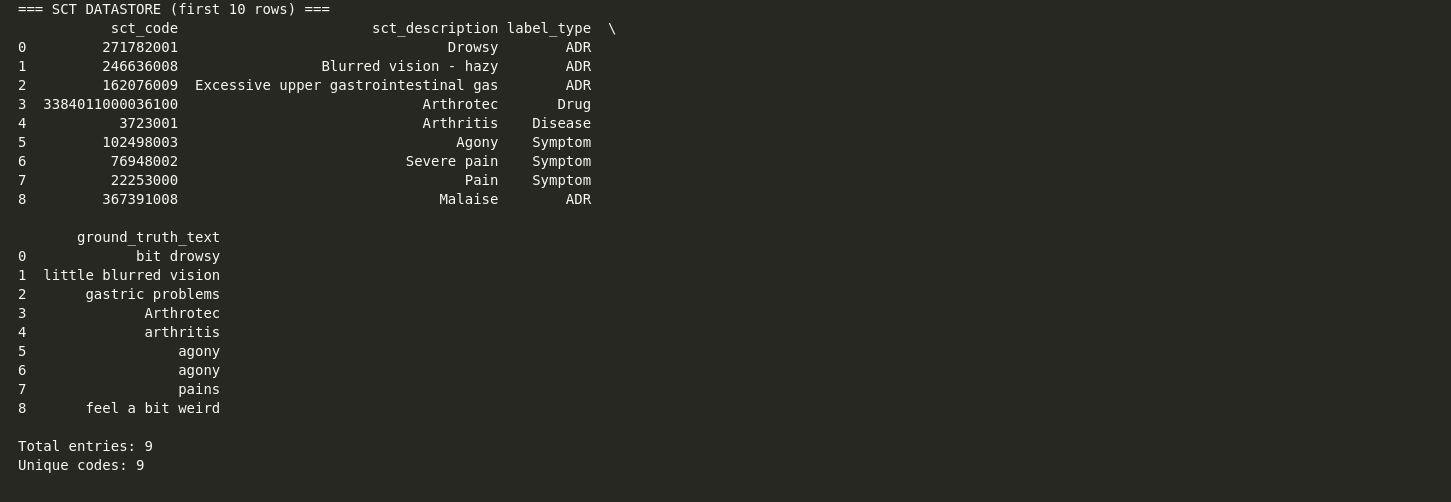